<center>
  <h2>Trabajo Laboratorio de Implementación III - MCD Virtual Cohorte 2022</h2>
  <h3>Forecasting para una Empresa de Consumo Masivo</h3>
  <h4>Experimento 17 AutoGluon</h4>
</center>

In [9]:
# !pip install autogluon
# !pip install tslearn
# !pip install kmodes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
import os
from sklearn.preprocessing import OneHotEncoder
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score

### Lectura de datos

In [10]:
df_ventas_product = pd.read_csv("C:/Users/usuario/otros/Desktop/MCD/6 Labo III/Forecasting Problem/Datasets/df_ventas_product_fill_extreme_values_095.csv", header = None)
df_ventas_product.columns = ["periodo", "product_id", "tn"]
df_ventas_product.head(5)

,periodo,product_id,tn
0,2017-01-01,20001,934.77222
1,2017-02-01,20001,798.01620
2,2017-03-01,20001,1303.35771
3,2017-04-01,20001,1069.96130
4,2017-05-01,20001,1502.20132


### Clusters de SERIES DE TIEMPO

- Preprocesamiento para armado clusters

In [11]:
df_pivot = df_ventas_product.pivot(index='periodo',
                                   columns='product_id',
                                   values='tn')

print(df_pivot.shape, df_pivot.columns)
df_pivot.head(1)

(36, 780) Index([20001, 20002, 20003, 20004, 20005, 20006, 20007, 20008, 20009, 20010,
       ...
       21248, 21252, 21256, 21259, 21262, 21263, 21265, 21266, 21267, 21276],
      dtype='int64', name='product_id', length=780)


product_id,20001,20002,20003,20004,20005,20006,20007,20008,20009,20010,...,21248,21252,21256,21259,21262,21263,21265,21266,21267,21276
periodo,,,,,,,,,,,,,,,,,,,,,
2017-01-01,934.77222,550.15707,1063.45835,555.91614,494.27011,528.40996,464.67137,523.04609,378.08172,441.25546,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# resample time series data and fill missing values with 0s
df_pivot.index = pd.DatetimeIndex(df_pivot.index)
df_pivot = df_pivot.resample('MS').sum().fillna(0)
print(df_pivot.shape, df_pivot.columns)
df_pivot.head(1)

(36, 780) Index([20001, 20002, 20003, 20004, 20005, 20006, 20007, 20008, 20009, 20010,
       ...
       21248, 21252, 21256, 21259, 21262, 21263, 21265, 21266, 21267, 21276],
      dtype='int64', name='product_id', length=780)


product_id,20001,20002,20003,20004,20005,20006,20007,20008,20009,20010,...,21248,21252,21256,21259,21262,21263,21265,21266,21267,21276
periodo,,,,,,,,,,,,,,,,,,,,,
2017-01-01,934.77222,550.15707,1063.45835,555.91614,494.27011,528.40996,464.67137,523.04609,378.08172,441.25546,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# transpose data to match format neeed for further processing
df_pivoted = df_pivot.T
df_pivoted = df_pivoted.reset_index()
print(df_pivoted.shape, df_pivoted.columns)
df_pivoted.set_index('product_id', inplace=True)
df_pivoted.head(1)

(780, 37) Index([       'product_id', 2017-01-01 00:00:00, 2017-02-01 00:00:00,
       2017-03-01 00:00:00, 2017-04-01 00:00:00, 2017-05-01 00:00:00,
       2017-06-01 00:00:00, 2017-07-01 00:00:00, 2017-08-01 00:00:00,
       2017-09-01 00:00:00, 2017-10-01 00:00:00, 2017-11-01 00:00:00,
       2017-12-01 00:00:00, 2018-01-01 00:00:00, 2018-02-01 00:00:00,
       2018-03-01 00:00:00, 2018-04-01 00:00:00, 2018-05-01 00:00:00,
       2018-06-01 00:00:00, 2018-07-01 00:00:00, 2018-08-01 00:00:00,
       2018-09-01 00:00:00, 2018-10-01 00:00:00, 2018-11-01 00:00:00,
       2018-12-01 00:00:00, 2019-01-01 00:00:00, 2019-02-01 00:00:00,
       2019-03-01 00:00:00, 2019-04-01 00:00:00, 2019-05-01 00:00:00,
       2019-06-01 00:00:00, 2019-07-01 00:00:00, 2019-08-01 00:00:00,
       2019-09-01 00:00:00, 2019-10-01 00:00:00, 2019-11-01 00:00:00,
       2019-12-01 00:00:00],
      dtype='object', name='periodo')


periodo,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,...,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01
product_id,,,,,,,,,,,,,,,,,,,,,
20001,934.77222,798.0162,1303.35771,1069.9613,1502.20132,1520.06539,1030.67391,1267.39462,1316.94604,1439.75563,...,1470.65653,1647.63848,1629.78233,1109.93769,1678.99318,1261.34529,1660.00561,1561.50552,1397.37231,1504.68856


In [14]:
%%time
# convert dataframe to time_series_dataset
X = to_time_series_dataset(df_pivoted.values)
# normalize time series to zero mean and unit variance
X_train = TimeSeriesScalerMeanVariance().fit_transform(X)
print(X.shape, X_train.shape)

(780, 36, 1) (780, 36, 1)
CPU times: total: 453 ms
Wall time: 462 ms


In [15]:
# create required directory structure
dir_paths = ['./tsl_LABO', './tsl_LABO/models', './tsl_LABO/plots']
for dir_path in dir_paths:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

In [16]:
%%time
# algorithm configuration
algo = "DTW_kmeans"
metric = "dtw"
# cluster configuration
N_CLUSTERS = 25

model= TimeSeriesKMeans(n_clusters=N_CLUSTERS,
                        metric=metric,
                        n_jobs=-1,
                        random_state=0)
y_pred = model.fit_predict(X_train)
model.to_pickle(f"./tsl_LABO/models/{algo}.pkl")

CPU times: total: 3min 12s
Wall time: 2min 55s


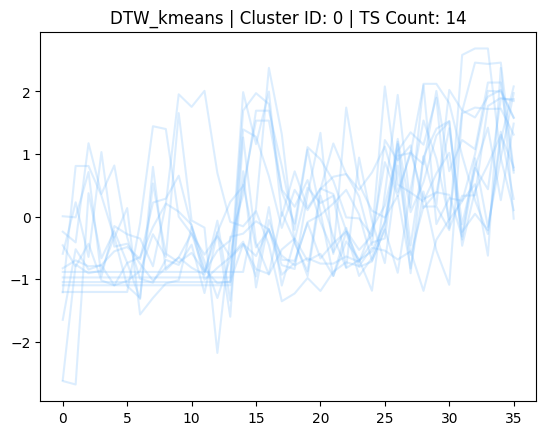

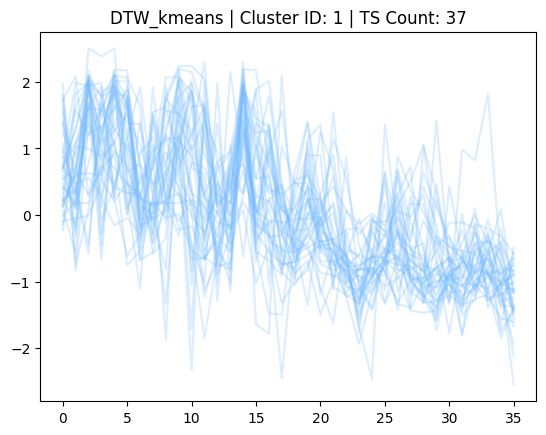

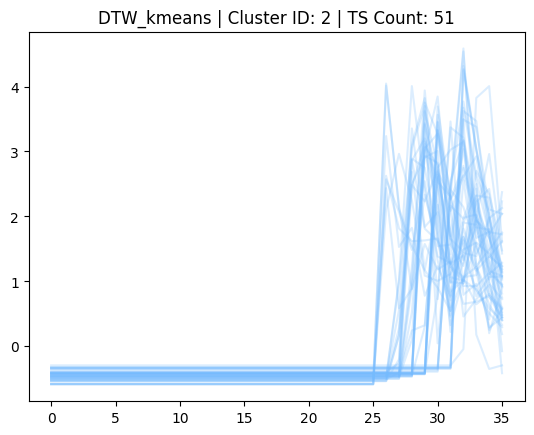

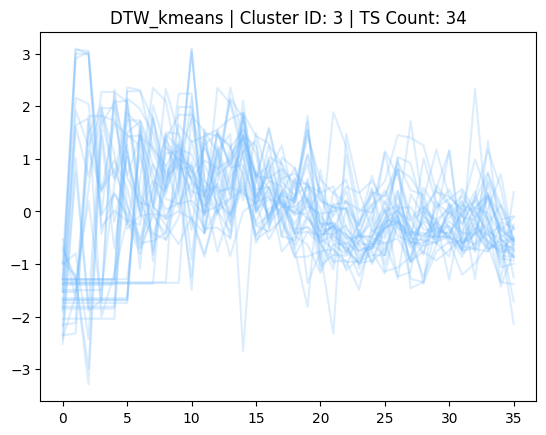

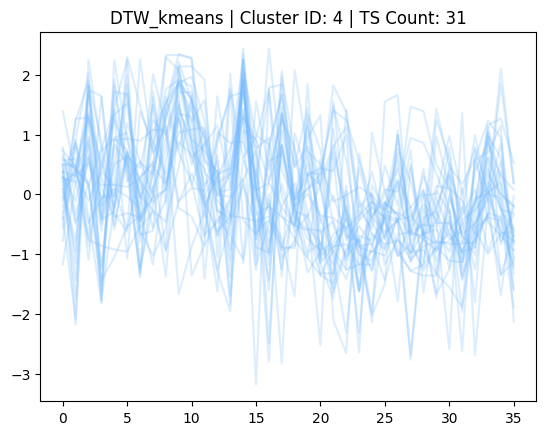

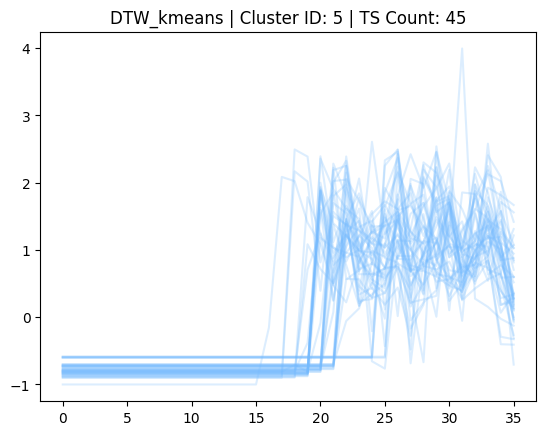

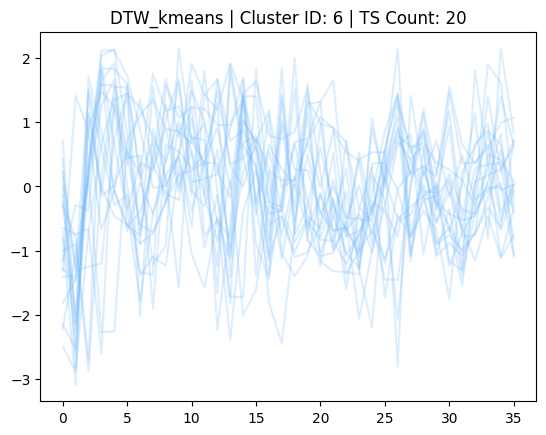

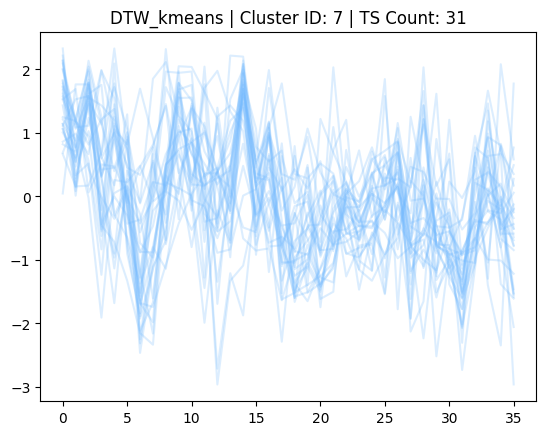

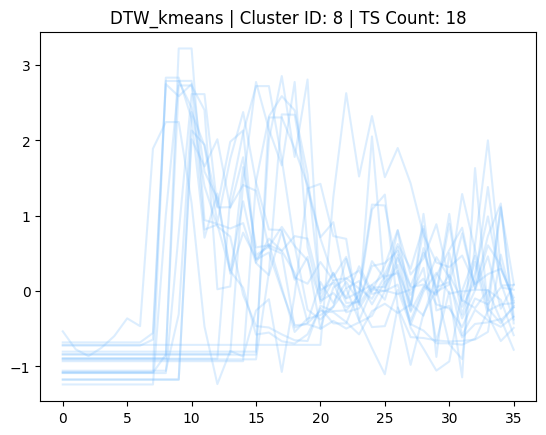

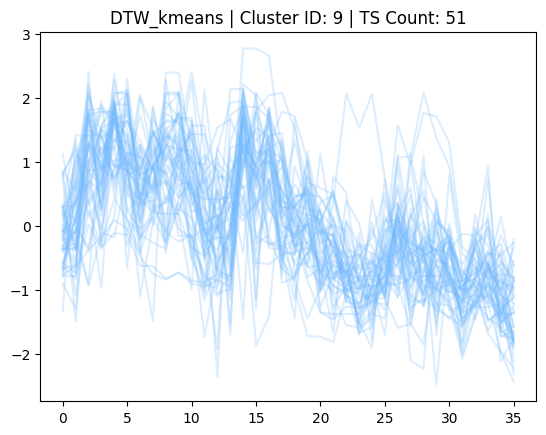

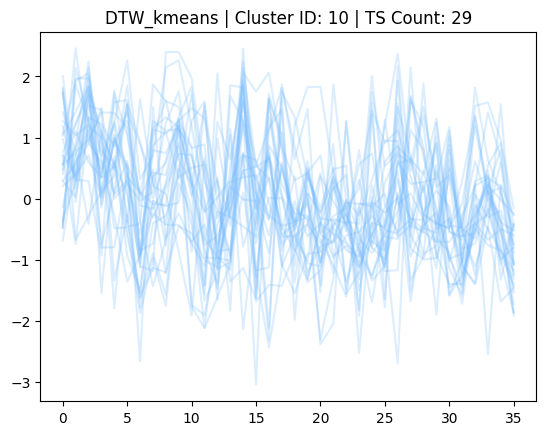

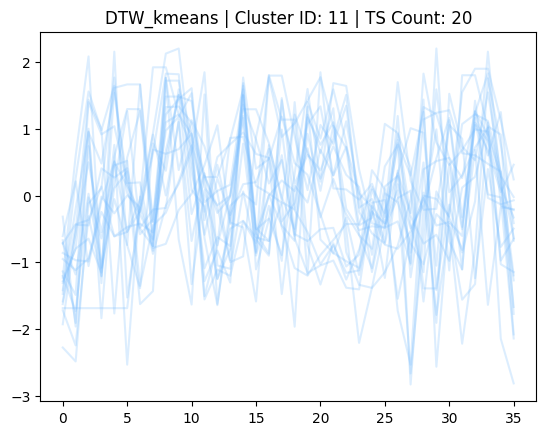

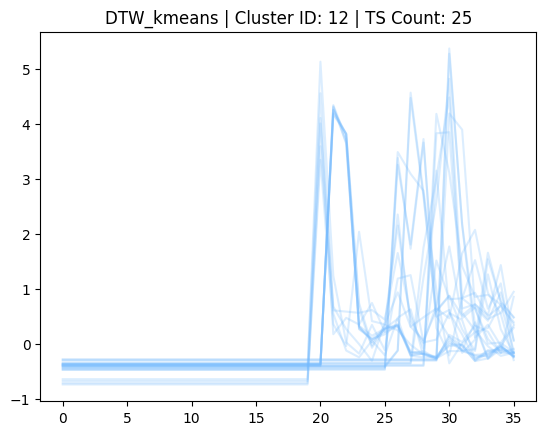

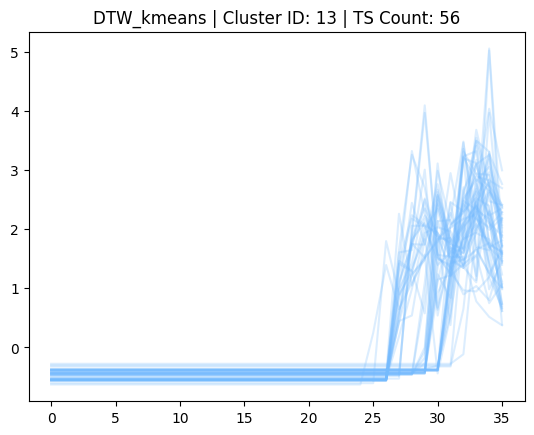

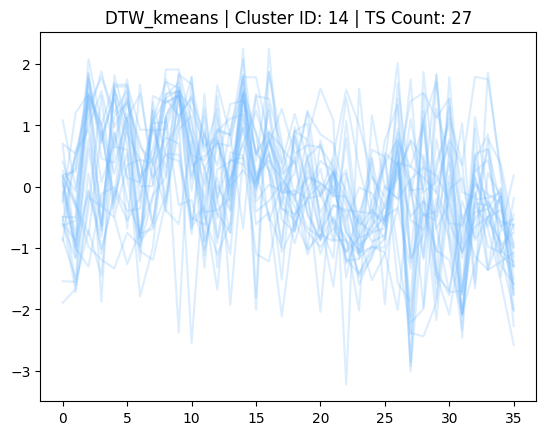

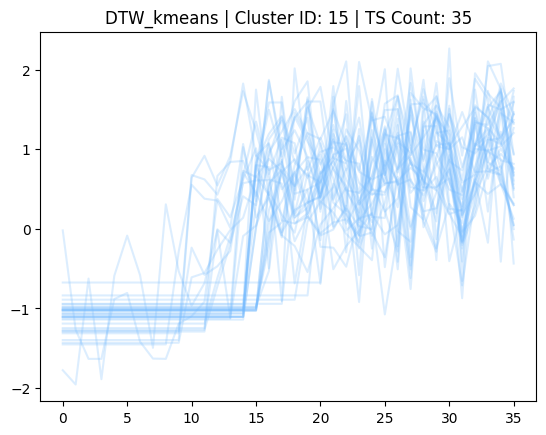

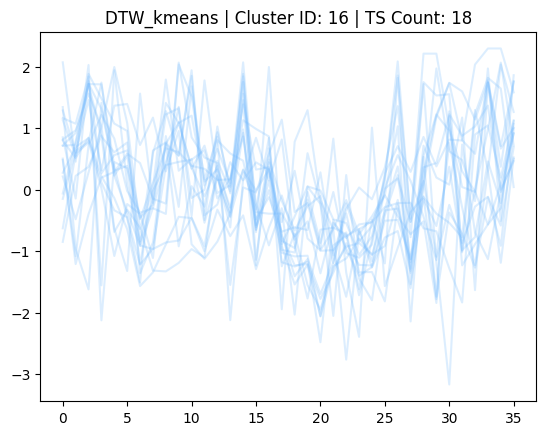

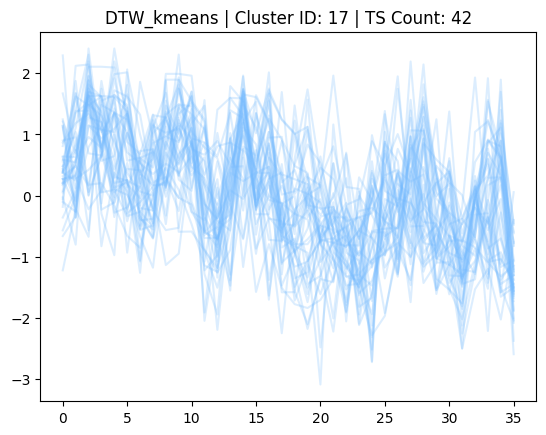

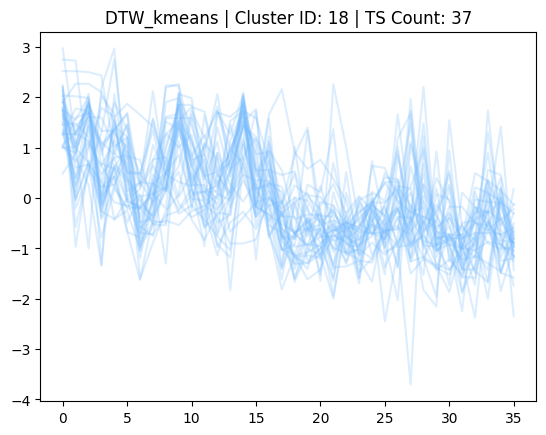

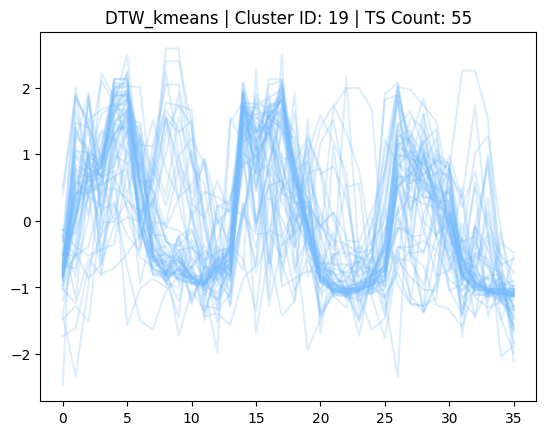

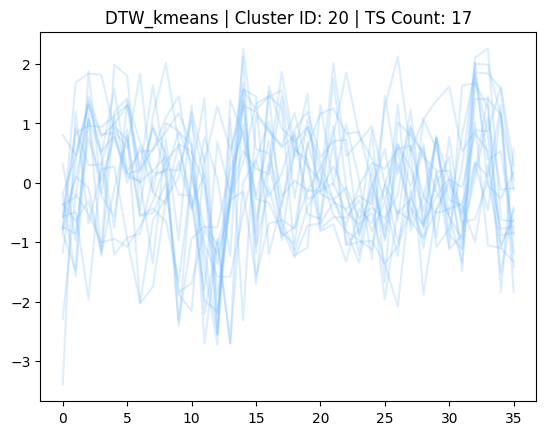

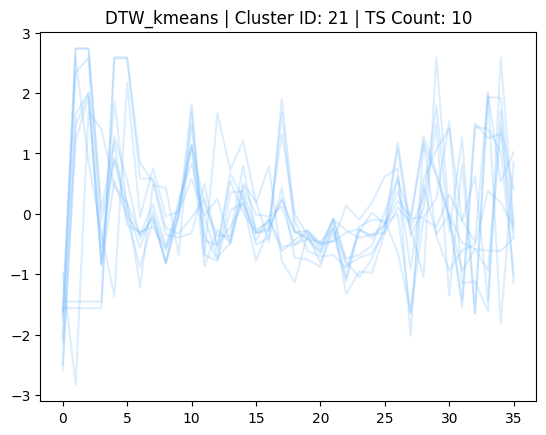

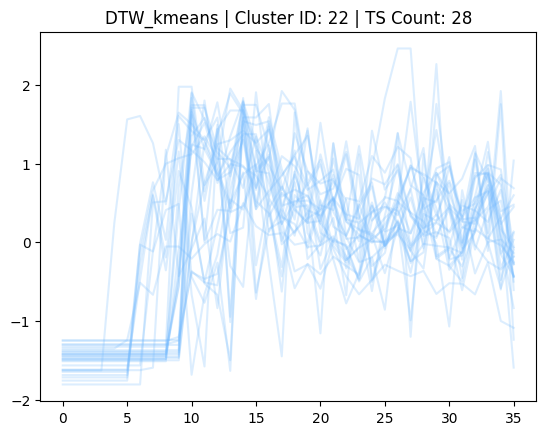

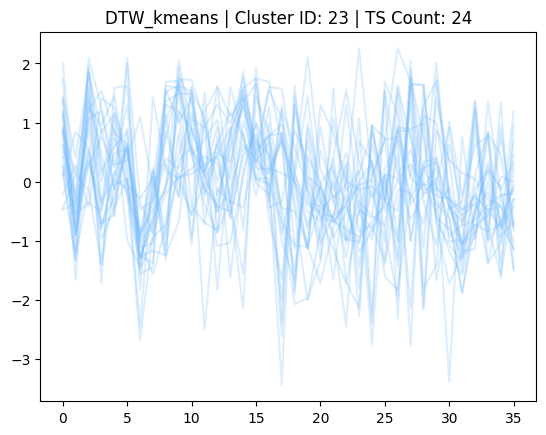

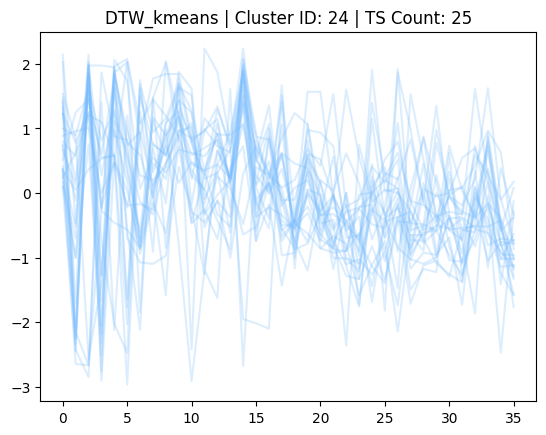

CPU times: total: 7.25 s
Wall time: 8.14 s


In [17]:
%%time

for yi in range(N_CLUSTERS):
    X_sub = X_train[y_pred == yi]
    ts_cnt = pd.Series(y_pred[y_pred == yi]).shape[0]
    fig = plt.figure()
    plt.title(f"{algo} | Cluster ID: {yi} | TS Count: {ts_cnt}")
    for xx in X_sub:
        plt.plot(xx.ravel(), color='xkcd:sky blue', alpha=0.25)
    # fig.savefig(f"./tsl_LABO/plots/{algo}_cls_lbl_{yi}.png", dpi=150)
    plt.show()
    plt.close()

In [18]:
len(df_pivoted)

780

In [19]:
len(y_pred)

780

In [20]:
df_pivoted_extended = pd.concat([df_pivoted.reset_index(), pd.DataFrame(y_pred, columns = ["cluster_id"])], axis = 1)
df_pivoted_extended

,product_id,2017-01-01 00:00:00,2017-02-01 00:00:00,2017-03-01 00:00:00,2017-04-01 00:00:00,2017-05-01 00:00:00,2017-06-01 00:00:00,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,...,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,2019-11-01 00:00:00,2019-12-01 00:00:00,cluster_id
0,20001,934.77222,798.01620,1303.35771,1069.96130,1502.20132,1520.06539,1030.67391,1267.394620,1316.946040,...,1647.638480,1629.782330,1109.93769,1678.99318,1261.34529,1660.00561,1561.505520,1397.37231,1504.68856,11
1,20002,550.15707,505.88633,834.73521,522.35365,843.43785,968.15756,845.39319,619.710780,1065.345290,...,1287.623460,1034.989270,928.36431,1066.44999,813.78215,1090.18771,1509.385713,1423.57739,1087.30855,15
2,20003,1063.45835,752.11520,917.16548,525.82591,620.48202,744.08829,785.12398,864.219280,1436.136245,...,565.337740,590.125150,662.38654,715.20314,635.59563,967.77116,1081.366450,948.29393,892.50129,4
3,20004,555.91614,508.20044,489.91328,512.05402,543.36670,590.50779,569.88117,1042.529790,1113.433648,...,466.709010,603.310810,667.19411,521.71519,482.13372,786.17140,1064.696330,723.94206,637.90002,8
4,20005,494.27011,551.43060,563.89955,662.59032,515.58711,528.58883,625.84925,1014.591725,1014.591725,...,624.998800,897.262970,876.39696,745.74978,536.66800,879.52808,996.782750,606.91173,593.24443,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,21263,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,...,0.018350,0.022580,0.00988,0.03387,0.03388,0.01128,0.015520,0.03247,0.01270,12
776,21265,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,...,0.279585,0.176350,0.05121,0.02959,0.01593,0.01707,0.109210,0.06600,0.05007,12
777,21266,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,...,0.278332,0.176340,0.05235,0.05916,0.01480,0.02844,0.118310,0.06713,0.05121,12
778,21267,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,...,0.122910,0.231581,0.05882,0.07452,0.04054,0.01830,0.096760,0.04052,0.01569,12


In [21]:
df_tts = pd.melt(df_pivoted_extended, id_vars=['product_id', 'cluster_id'])
df_tts.columns = ['product_id', 'cluster_id', 'periodo', 'tn']
df_tts = df_tts[['periodo', 'product_id', 'cluster_id', 'tn']]
df_tts

,periodo,product_id,cluster_id,tn
0,2017-01-01 00:00:00,20001,11,934.77222
1,2017-01-01 00:00:00,20002,15,550.15707
2,2017-01-01 00:00:00,20003,4,1063.45835
3,2017-01-01 00:00:00,20004,8,555.91614
4,2017-01-01 00:00:00,20005,11,494.27011
...,...,...,...,...
28075,2019-12-01 00:00:00,21263,12,0.01270
28076,2019-12-01 00:00:00,21265,12,0.05007
28077,2019-12-01 00:00:00,21266,12,0.05121
28078,2019-12-01 00:00:00,21267,12,0.01569


In [22]:
len(df_tts[df_tts.tn != 0]) == len(df_ventas_product)
# df_tts tiene más registros porque las fechas sin tn por serie fueron completados con 0

True

In [23]:
df_tts.tn.sum()

1110207.065571

In [24]:
df_ventas_product.tn.sum()

1110207.065571

### Modelado

In [25]:
df = df_tts.rename(columns = {"cluster_id":"cluster"})

In [26]:
# N_CLUSTERS = n_clusters_optimo

# Crear un bucle for que itere sobre cada cluster_id
for cluster_id in range(N_CLUSTERS):
    # Filtrar el dataframe original df_tts por el cluster_id actual
    df_cluster = df[df.cluster == cluster_id]
    # Eliminar la columna "cluster_id" del dataframe filtrado
    df_cluster = df_cluster.drop(columns={"cluster"})
    # Imprimir información sobre el cluster actual
    print(f"---------------C{cluster_id}---------------")
    print(df_cluster.periodo.min(), df_cluster.periodo.max())
    print(len(df_cluster.drop_duplicates(subset="product_id")))
    # Asignar el dataframe resultante a una variable específica para cada cluster (opcional)
    globals()[f"df_ventas_product_cluster{cluster_id}"] = df_cluster

---------------C0---------------
2017-01-01 00:00:00 2019-12-01 00:00:00
14
---------------C1---------------
2017-01-01 00:00:00 2019-12-01 00:00:00
37
---------------C2---------------
2017-01-01 00:00:00 2019-12-01 00:00:00
51
---------------C3---------------
2017-01-01 00:00:00 2019-12-01 00:00:00
34
---------------C4---------------
2017-01-01 00:00:00 2019-12-01 00:00:00
31
---------------C5---------------
2017-01-01 00:00:00 2019-12-01 00:00:00
45
---------------C6---------------
2017-01-01 00:00:00 2019-12-01 00:00:00
20
---------------C7---------------
2017-01-01 00:00:00 2019-12-01 00:00:00
31
---------------C8---------------
2017-01-01 00:00:00 2019-12-01 00:00:00
18
---------------C9---------------
2017-01-01 00:00:00 2019-12-01 00:00:00
51
---------------C10---------------
2017-01-01 00:00:00 2019-12-01 00:00:00
29
---------------C11---------------
2017-01-01 00:00:00 2019-12-01 00:00:00
20
---------------C12---------------
2017-01-01 00:00:00 2019-12-01 00:00:00
25
---------

In [27]:
total_productos_unicos = 0

# Crear un bucle for que itere sobre cada cluster_id
for cluster_id in range(N_CLUSTERS):
    # Obtener el nombre de la variable del dataframe del cluster actual
    df_name = f"df_ventas_product_cluster{cluster_id}"
    
    # Verificar si la variable existe en el entorno global
    if df_name in globals():
        # Obtener el dataframe del cluster actual
        df_cluster = globals()[df_name]
        
        # Calcular la cantidad de productos únicos en el cluster actual
        productos_unicos = len(df_cluster.drop_duplicates(subset="product_id"))
        
        # Sumar al total de productos únicos
        total_productos_unicos += productos_unicos

# Imprimir el total de productos únicos en todos los clusters
print("Total de productos únicos en todos los clusters:", total_productos_unicos)

Total de productos únicos en todos los clusters: 780


In [28]:
# Crear un bucle for que itere sobre cada cluster_id
for cluster_id in range(N_CLUSTERS):
    # Construir el nombre de la variable del dataframe del cluster actual
    df_name = f"df_ventas_product_cluster{cluster_id}"
    
    # Verificar si la variable existe en el entorno global
    if df_name in globals():
        # Obtener el dataframe del cluster actual
        df_cluster = globals()[df_name]
        
        # Renombrar las columnas especificadas en el dataframe del cluster actual
        df_cluster = df_cluster.rename(columns={"periodo": "timestamp", "product_id": "item_id", "tn": "target"})
        
        # Asignar el dataframe renombrado de vuelta a la variable global
        globals()[df_name] = df_cluster

In [29]:
df_ventas_product_cluster0.head(1)

,timestamp,item_id,target
100,2017-01-01 00:00:00,20116,63.35257


In [30]:
df_ventas_product_cluster9.head(1)

,timestamp,item_id,target
6,2017-01-01 00:00:00,20007,464.67137


In [31]:
# Lista para almacenar los objetos TimeSeriesDataFrame
time_series_dataframes = []

# Crear un bucle for que itere sobre cada cluster_id
for cluster_id in range(N_CLUSTERS):
    # Construir el nombre de la variable del dataframe del cluster actual
    df_name = f"df_ventas_product_cluster{cluster_id}"
    
    # Verificar si la variable existe en el entorno actual (recomendado usar locals())
    if df_name in locals():
        # Obtener el dataframe del cluster actual
        df_cluster = locals()[df_name]
        # Crear un objeto TimeSeriesDataFrame con el dataframe actual
        data = TimeSeriesDataFrame(df_cluster)
        # Agregar el objeto TimeSeriesDataFrame a la lista
        time_series_dataframes.append(data)
        # Opcional: Asignar el objeto a una variable individual si es necesario
        globals()[f"data{cluster_id}"] = data

In [32]:
predictors = []
for cluster_id in range(N_CLUSTERS):
    print(f"PREDICTOR {cluster_id}")
    data = globals()[f"data{cluster_id}"]  # Assuming data variables are named as data0, data1, ..., data9
    predictor = TimeSeriesPredictor(target='target', prediction_length=2, freq="M").fit(data, num_val_windows = 3)
    predictors.append(predictor)

Frequency 'M' stored as 'ME'
Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels\ag-20240707_151852'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.2
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       1.83 GB / 7.88 GB (23.2%)
Disk Space Avail:   3.98 GB / 110.21 GB (3.6%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'ME',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 2,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'MS' has been resamp

PREDICTOR 0


Provided train_data has 504 rows, 14 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 12:18:54
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.3673       = Validation score (-WQL)
	5.44    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.3119       = Validation score (-WQL)
	20.29   s     = Training runtime
	0.12    s     = Validation (prediction) runtime
Training t

PREDICTOR 1


Provided train_data has 1332 rows, 37 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 12:47:07
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.3743       = Validation score (-WQL)
	6.23    s     = Training runtime
	0.11    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.3537       = Validation score (-WQL)
	28.19   s     = Training runtime
	0.12    s     = Validation (prediction) runtime
Training 

PREDICTOR 2


Provided train_data has 1836 rows, 51 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 13:20:13
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.8282       = Validation score (-WQL)
	5.20    s     = Training runtime
	0.11    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.5265       = Validation score (-WQL)
	47.49   s     = Training runtime
	0.13    s     = Validation (prediction) runtime
Training 

PREDICTOR 3


train_data with frequency 'MS' has been resampled to frequency 'ME'.
Provided train_data has 1224 rows, 34 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 13:56:27
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.3451       = Validation score (-WQL)
	5.00    s     = Training runtime
	0.08    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.3539       = Validation score (-WQL)
	16.68   s     = Traini

PREDICTOR 4


Provided train_data has 1116 rows, 31 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 14:22:30
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.2003       = Validation score (-WQL)
	3.57    s     = Training runtime
	0.08    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.2109       = Validation score (-WQL)
	13.58   s     = Training runtime
	0.10    s     = Validation (prediction) runtime
Training 

PREDICTOR 5


Provided train_data has 1620 rows, 45 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 14:45:09
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.5171       = Validation score (-WQL)
	3.26    s     = Training runtime
	0.08    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.2851       = Validation score (-WQL)
	22.16   s     = Training runtime
	0.26    s     = Validation (prediction) runtime
Training 

PREDICTOR 6


Provided train_data has 720 rows, 20 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 15:06:24
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.2036       = Validation score (-WQL)
	3.25    s     = Training runtime
	0.05    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.2280       = Validation score (-WQL)
	8.77    s     = Training runtime
	0.09    s     = Validation (prediction) runtime
Training t

PREDICTOR 7


Provided train_data has 1116 rows, 31 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 15:25:45
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.1792       = Validation score (-WQL)
	3.70    s     = Training runtime
	0.05    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.2425       = Validation score (-WQL)
	18.02   s     = Training runtime
	0.08    s     = Validation (prediction) runtime
Training 

PREDICTOR 8


Provided train_data has 648 rows, 18 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 15:49:48
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.2672       = Validation score (-WQL)
	3.83    s     = Training runtime
	0.05    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.3009       = Validation score (-WQL)
	14.02   s     = Training runtime
	0.10    s     = Validation (prediction) runtime
Training t

PREDICTOR 9


Provided train_data has 1836 rows, 51 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 16:12:05
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.3110       = Validation score (-WQL)
	4.11    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.2950       = Validation score (-WQL)
	17.12   s     = Training runtime
	0.11    s     = Validation (prediction) runtime
Training 

PREDICTOR 10


Provided train_data has 1044 rows, 29 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 16:37:59
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.2463       = Validation score (-WQL)
	4.36    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.3107       = Validation score (-WQL)
	12.77   s     = Training runtime
	0.11    s     = Validation (prediction) runtime
Training 

PREDICTOR 11


Provided train_data has 720 rows, 20 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 17:04:37
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.1997       = Validation score (-WQL)
	5.19    s     = Training runtime
	0.05    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.2294       = Validation score (-WQL)
	12.94   s     = Training runtime
	0.10    s     = Validation (prediction) runtime
Training t

PREDICTOR 12


Provided train_data has 900 rows, 25 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 17:24:55
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.8223       = Validation score (-WQL)
	3.68    s     = Training runtime
	0.05    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.8636       = Validation score (-WQL)
	17.31   s     = Training runtime
	0.10    s     = Validation (prediction) runtime
Training t

PREDICTOR 13


Provided train_data has 2016 rows, 56 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 17:48:47
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.8503       = Validation score (-WQL)
	4.33    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.4990       = Validation score (-WQL)
	31.95   s     = Training runtime
	0.12    s     = Validation (prediction) runtime
Training 

PREDICTOR 14


Provided train_data has 972 rows, 27 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 18:18:53
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.2436       = Validation score (-WQL)
	3.62    s     = Training runtime
	0.04    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.2291       = Validation score (-WQL)
	16.33   s     = Training runtime
	0.10    s     = Validation (prediction) runtime
Training t

PREDICTOR 15


Provided train_data has 1260 rows, 35 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 18:45:12
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.1988       = Validation score (-WQL)
	3.29    s     = Training runtime
	0.05    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.1759       = Validation score (-WQL)
	14.66   s     = Training runtime
	0.10    s     = Validation (prediction) runtime
Training 

PREDICTOR 16


Provided train_data has 648 rows, 18 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 19:06:52
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.3385       = Validation score (-WQL)
	3.65    s     = Training runtime
	0.05    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.2842       = Validation score (-WQL)
	14.97   s     = Training runtime
	0.09    s     = Validation (prediction) runtime
Training t

PREDICTOR 17


Provided train_data has 1512 rows, 42 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 19:27:17
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.2842       = Validation score (-WQL)
	4.47    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.2877       = Validation score (-WQL)
	20.38   s     = Training runtime
	0.10    s     = Validation (prediction) runtime
Training 

PREDICTOR 18


Provided train_data has 1332 rows, 37 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 19:48:19
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.2216       = Validation score (-WQL)
	4.29    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.2512       = Validation score (-WQL)
	15.07   s     = Training runtime
	0.11    s     = Validation (prediction) runtime
Training 

PREDICTOR 19


Provided train_data has 1980 rows, 55 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 20:10:09
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.2883       = Validation score (-WQL)
	4.56    s     = Training runtime
	0.09    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.2686       = Validation score (-WQL)
	20.10   s     = Training runtime
	0.11    s     = Validation (prediction) runtime
Training 

PREDICTOR 20


Provided train_data has 612 rows, 17 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 20:34:37
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.1656       = Validation score (-WQL)
	4.00    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.1821       = Validation score (-WQL)
	10.19   s     = Training runtime
	0.10    s     = Validation (prediction) runtime
Training t

PREDICTOR 21


Provided train_data has 360 rows, 10 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 20:55:26
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.4026       = Validation score (-WQL)
	3.82    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.4347       = Validation score (-WQL)
	6.10    s     = Training runtime
	0.10    s     = Validation (prediction) runtime
Training t

PREDICTOR 22


Provided train_data has 1008 rows, 28 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 21:12:32
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.3149       = Validation score (-WQL)
	3.40    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.3740       = Validation score (-WQL)
	11.91   s     = Training runtime
	0.10    s     = Validation (prediction) runtime
Training 

PREDICTOR 23


Provided train_data has 864 rows, 24 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 21:33:29
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.2350       = Validation score (-WQL)
	3.51    s     = Training runtime
	0.04    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.2457       = Validation score (-WQL)
	12.15   s     = Training runtime
	0.09    s     = Validation (prediction) runtime
Training t

PREDICTOR 24


Provided train_data has 900 rows, 25 time series. Median time series length is 36 (min=36, max=36). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-07-07 21:54:58
Models that will be trained: ['SeasonalNaive', 'RecursiveTabular', 'DirectTabular', 'CrostonSBA', 'NPTS', 'DynamicOptimizedTheta', 'AutoETS', 'AutoARIMA', 'Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST']
Training timeseries model SeasonalNaive. 
	-0.2361       = Validation score (-WQL)
	3.24    s     = Training runtime
	0.05    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-0.2811       = Validation score (-WQL)
	9.86    s     = Training runtime
	0.09    s     = Validation (prediction) runtime
Training t

In [33]:
predictions_list = []
for cluster_id in range(N_CLUSTERS):
    predictor = predictors[cluster_id]  # Accede al predictor correspondiente desde la lista
    data = globals()[f"data{cluster_id}"]  # Accede dinámicamente a los datos correspondientes
    predictions = predictor.predict(data)
    predictions_list.append(predictions)

# Concatenar todas las predicciones en un solo DataFrame
concatenated_predictions = pd.concat(predictions_list)

data with frequency 'MS' has been resampled to frequency 'ME'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
data with frequency 'MS' has been resampled to frequency 'ME'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
data with frequency 'MS' has been resampled to frequency 'ME'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
data with frequency 'MS' has been resampled to frequency 'ME'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
data with frequency 'MS' has been resampled to frequency 'ME'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
data with frequency 'MS' has been resampled to frequency 'ME'.
Model not specified in predict, will default to the model with the best validation scor

In [34]:
predictions_v1 = concatenated_predictions.copy()
predictions_v1 = predictions_v1.reset_index()
predictions_v1 = predictions_v1[["item_id", "timestamp", "mean"]]
predictions_v1 = predictions_v1[predictions_v1.timestamp == "2020-02-29"]
predictions_v1 = predictions_v1.drop(columns = {"timestamp"})
predictions_v1 = predictions_v1.rename(columns = {"item_id":"product_id", "mean":"tn"})
predictions_v1.head(5)

,product_id,tn
1,20116,114.580435
3,20148,78.014056
5,20150,105.948997
7,20162,54.222896
9,20227,48.982919


In [35]:
len(predictions_v1.product_id.unique())

780

In [36]:
predictions_v1.to_csv("C:/Users/usuario/otros/Desktop\MCD/6 Labo III/Forecasting Problem/Outputs/prediccion_autogluon_25cluster_products_outlier.csv", sep = ",", index = False)